In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd


from keras.datasets import mnist, fashion_mnist
import keras as kb
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


# Autoencoders

Autoencoders are our first experience with *Unsupervised* Neural Networks. The goal of an Autoencoder is to learn how to compress the data with the **encoder** portion of the network, and then uncompress it with the **decoder** portion.

In order to enforce this compression we typically either:

- have a hidden layer with **low dimensionality** (very few nodes)
OR
- enforce **sparcity** (many nodes are 0) in the hidden layer

## Denoising as Regularization
In addition to the two types of penalties we talked about (penalties on the hidden layer and penalties on the derivative) which both help regularize our Autoencoders, we also talked about **Denoising Autoencoders**. DAE's add a little bit of noise (i.e. adding small random values to our input) to our data but *still ask the model to return the original input*. Adding a little bit of noise to the input forces the AE to learn that small changes (noise) to the input should not drastically change what the output should be.


## Autoencoders as Non-Linear Principal Component Analysis
We often say that autoencoders do non-linear PCA, because like PCA, autoencoders learn to represent *most* of the information in the data using a smaller set of variables. However unlike PCA, the "components" or compressed representation of the data doesn't have to be a *linear combination* of the input variables. We can add non-linear activation funcitons, or have a *deep* encoder which allows more complex combinations of the input variables.

<img src="https://drive.google.com/uc?export=view&id=1q670OFb8hLd6FhGcBmJcqwfcmw5uz9Ag" alt="Q" width = "200px"/>

## Convolutional Autoencoders
And the encoder and decoder don't have to be just Dense, Feed Forward layers. We can also use Convolutional and Pooling layers in order to make Convolutional Autoencoders which can compress images.

<img src="https://drive.google.com/uc?export=view&id=1aJ2MXRfHqMt07Z4ukICUkRqc2t9Dr8y9" alt="Q" width = "400px" />


## Building a FF Autoencoder in Keras
We can theoretically build an autoencoder using a simple stack of layers (e.g. through `Sequential`), however, we're often interested in using the encoder and decoder *separately* once the model is trained, so we'll often use the Functional API to build our Autoencoders so that we can separate them.

In [ ]:
inshape = 30
encoding_dim = 5

input_data = kb.Input(shape = (inshape,), name = "ae_input")
encoded = kb.layers.Dense(encoding_dim, name = "encoding")(input_data)
decoded = kb.layers.Dense(inshape, name = "decoding")(encoded)

# AE
autoencoder = kb.Model(inputs = input_data,
                       outputs = decoded)

# encoder
encoder = kb.Model(inputs = input_data,
                   outputs = encoded)


# decoder
encoded_input = kb.Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = kb.Model(inputs = encoded_input,
                   outputs = decoder_layer(encoded_input))

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_input (InputLayer)       [(None, 30)]              0         
                                                                 
 encoding (Dense)            (None, 5)                 155       
                                                                 
 decoding (Dense)            (None, 30)                180       
                                                                 
Total params: 335 (1.31 KB)
Trainable params: 335 (1.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ae_input (InputLayer)       [(None, 30)]              0         
                                                                 
 encoding (Dense)            (None, 5)                 155       
                                                                 
Total params: 155 (620.00 Byte)
Trainable params: 155 (620.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 decoding (Dense)            (None, 30)                180       
                                                                 
Total params: 180 (720.00 Byte)
Trainable params: 180 (720.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Loading in Data

Loading in Data to use in Tensorflow can be a little tricky when it's not data that comes pre-loaded with tf.

First we're going to load in a Breast Cancer dataset using pandas, and select the columns that we want to put into our autoencoder (all the different features of the breast cancer biopsy).

In [ ]:
# load in data
bc = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/BreastCancer.csv")

# grab necessary columns
feat = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
bc_compress = bc[feat]


Next, we'll do a train/test split.

We can either use `sklearn`'s `train_test_split()` or we can do it through tensorflow. Both are shown below.

### Tensorflow TTS
First we calculate how many data points go in train, and how many go in test.

Then we use tensorflow's `split()` function to do the train test split. We need to shuffle our data using `tf.random.shuffle()` first, otherwise it will split our data so that the first rows are in the train and the last rows are in test (this is like setting the `shuffle = True` argument in a `train_test_split()` or `KFold()` in `sklearn`)

In [ ]:
# TTS

# # calculate the number of data points in each set
# test_prop = bc_compress_tf.shape[0]//5
# train_prop = bc_compress_tf.shape[0] - test_prop

# # split
# X_train, X_test = tf.split(tf.random.shuffle(bc_compress_tf), #shuffle before splitting
#                            [train_prop, test_prop], # number of data points in each set
#                            0) # split the rows, not columns

# print(X_train.shape, X_test.shape)

X = bc_compress
y = bc["diagnosis"]

lb = LabelBinarizer()
y = lb.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, )

In [ ]:
# compile and train

autoencoder.compile(loss = "mean_squared_error", optimizer = "adam")
history = autoencoder.fit(X_train, X_train,
                epochs = 500,
                validation_data = (X_test, X_test),
                verbose = 0)

Yay! We trained an autoencoder to compress our breast cancer data.

We now have a few options of what to do with it. One option is to use the `encoder` to compress all our our data and then feed that data through a predictive model.

In [ ]:
x_train_compressed = encoder(tf.convert_to_tensor(X_train))
x_test_compressed = encoder(tf.convert_to_tensor(X_test))

In [ ]:
model = kb.Sequential([
    kb.layers.Dense(5, input_shape = (5,), activation = "relu"),
    kb.layers.Dense(3, activation = "relu"),
    kb.layers.Dense(2, activation = "relu"),
    kb.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])
history = model.fit(x_train_compressed, y_train,
          epochs = 100,
          validation_data = (x_test_compressed, y_test),
          verbose = 0)
model.evaluate(x_train_compressed, y_train)
model.evaluate(x_test_compressed, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 0.6390 - accuracy: 0.6783


[0.6389818787574768, 0.6783216595649719]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 30        
                                                                 
 dense_1 (Dense)             (None, 3)                 18        
                                                                 
 dense_2 (Dense)             (None, 2)                 8         
                                                                 
 dense_3 (Dense)             (None, 1)                 3         
                                                                 
Total params: 59 (236.00 Byte)
Trainable params: 59 (236.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Another option we have is to add the encoder as a **non-trainable** layer to our neural network. This way the NN will take in raw data, the encoder will compress it, and then pass it along to the next layer of the network.

In [ ]:
# tell our model NOT to change the encoder
encoder.trainable = False

input = kb.Input(shape = (30,))
x = encoder(input)
x = kb.layers.Dense(5, input_shape = (5,), activation = "relu", name = "5Dense")(x)
x = kb.layers.Dense(3, activation = "relu", name = "3Dense")(x)
x = kb.layers.Dense(2, activation = "relu", name = "2Dense")(x)
output = kb.layers.Dense(1, activation = "sigmoid")(x)


model_encoded = kb.Model(inputs = input,
                         outputs = output)

In [ ]:
model_encoded.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 model_1 (Functional)        (None, 5)                 155       
                                                                 
 5Dense (Dense)              (None, 5)                 30        
                                                                 
 3Dense (Dense)              (None, 3)                 18        
                                                                 
 2Dense (Dense)              (None, 2)                 8         
                                                                 
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 214 (856.00 Byte)
Trainable params: 59 (236.0

In [ ]:
model_encoded.compile(loss = "binary_crossentropy",
                      optimizer = "sgd",
                      metrics = ["accuracy"])
model_encoded.fit(X_train, y_train,
          epochs = 200,
          validation_data = (X_test, y_test),
                  verbose = 0)

model_encoded.evaluate(X_train, y_train)
model_encoded.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.6387 - accuracy: 0.6783


[0.6387114524841309, 0.6783216595649719]

## Denoising Convolutional AE

(NOTE: because we're scaling the pixel values to be between 0-1, we can use a `sigmoid` activation and a `binary_cross_entropy` loss. `binary_cross_entropy` works with values between 0-1. IF you are not scaling your pixel values, DO NOT use `binary_cross_entropy`, instead use something like `mean_squared_error` or `mean_absolute_error` and a `linear` activation.)


Now let's build a de-noising autoencoder. First, we load in our data and add a little bit of noise.

In [ ]:
# load data from keras
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# rescale and reshape data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# add noise
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# make sure noise doesnt give us an invalid value outside [0,1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

11490434/11490434 [==============================] - 0s 0us/step


let's plot some of the noisy and non-noisy data!

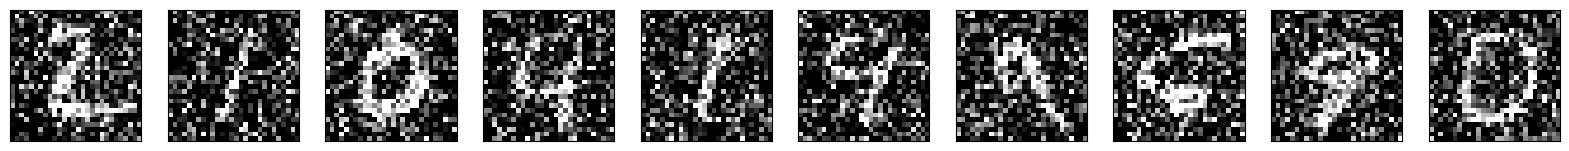

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

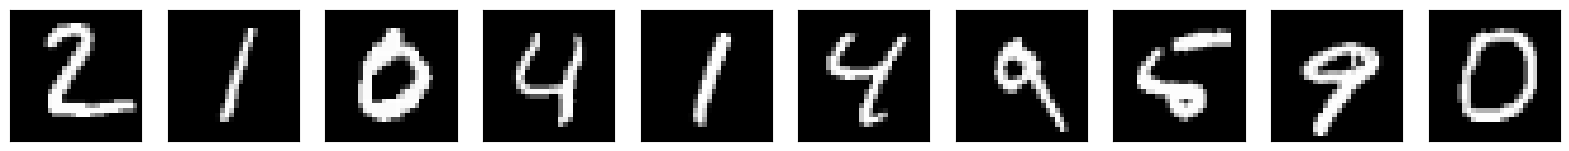

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### Building the DAE
Now we need to build our model. Remember, the goal of the encoding portion of the model is to compress our image (meaning we want it's output to be SMALLER than the image).

Then we need to create some layers that learn to de-compress the image. We can use any combination of `UpSampling2D()` layers (the opposite of `MaxPooling2D()`), `Conv2D()` layers, or `Conv2DTranspose()` layers (the opposite of `Conv2D()`). What we want to keep in mind is that our **input** needs to be the same dimensions as our **output**.

For this example (from Keras), you're going to use `UpSampling2D()` to upscale your compressed image, and a `Conv2D()` layer at the end to get our image back to 1 channel (rather than 32).

In [ ]:
# set input to be a 28x28 image
input_img = kb.Input(shape=(28, 28, 1))

# encoding
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = kb.layers.MaxPooling2D((2, 2), padding='same')(x)
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = kb.layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

# decoding
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = kb.layers.UpSampling2D((2, 2))(x)
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = kb.layers.UpSampling2D((2, 2))(x)
decoded = kb.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = kb.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=1,
                validation_data=(x_test_noisy, x_test))

1875/1875 [==============================] - 142s 75ms/step - loss: 0.1275 - val_loss: 0.1041


In [ ]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 32)          9248

In [ ]:
# We're not going to use this today, but we COULD if we wanted...
# create encoder model
encoder_conv = kb.Model(inputs = autoencoder.input,
                        outputs = encoded)

# get compressed image
x_example = encoder_conv(x_train_noisy[0])

#### Plot DAE
Now that we've trained the denoising autoencoder, let's see how it does on a few samples.

In [ ]:
# denoise using DAE
x_train_pred = autoencoder.predict(x_train_noisy)

1875/1875 [==============================] - 35s 19ms/step


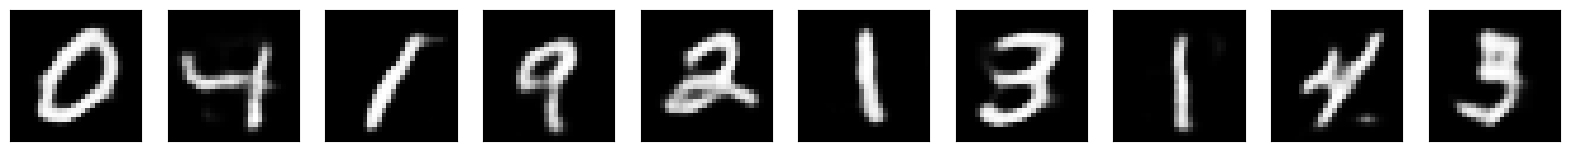

In [ ]:
# plot denoised images
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train_pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

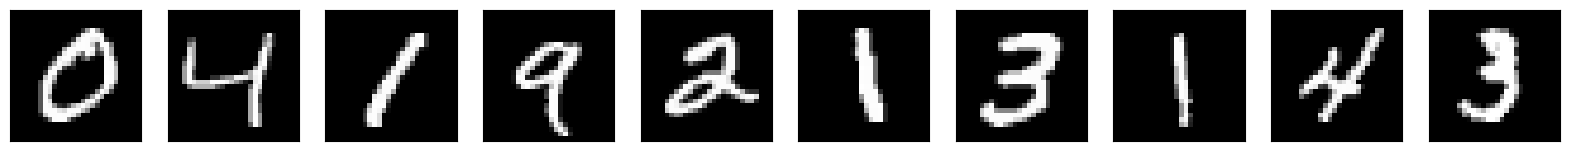

In [ ]:
# plot true images
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(Because we did this the simple way and added noise to our dataset, the noise for a given sample will never change. We also could add a `GaussianNoise()` layer to our model in order to change the noise each time, sorta like the data augmentation layers that we used before.)

In [ ]:
# W = 28 # input height/width
# K = 3 # kernel size
# P = 0 # padding
# S = 1 # stride

# # output dimensions
# ((W - K + P + S)/S)

# set input to be a 28x28 image
input_img = kb.Input(shape=(28, 28, 1))

# encoding
#28,28,1 --> 28,28,32 --> 14,14,32 --> 14,14,32 --> 7,7,32
x = kb.layers.GaussianNoise(0.5)(input_img)
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = kb.layers.MaxPooling2D((2, 2), padding='same')(x)
x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = kb.layers.MaxPooling2D((2, 2), padding='same')(x)

# # encoding alternate
# #28,28,1 --> 14,14,32 --> 7,7,32
# x = kb.layers.GaussianNoise(0.5)(input_img)
# x = kb.layers.Conv2D(32, (2, 2), strides = (2,2), activation='relu', padding='valid')(x)
# encoded = kb.layers.Conv2D(32, (2, 2), strides = (2,2), activation='relu', padding='valid')(x)


# At this point the representation is (7, 7, 32)

# # decoding
# # 7,7,32 --> 7,7,32 --> 14,14,32 --> 14,14,32 --> 28,28,32 --> 28,28,1
# x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = kb.layers.UpSampling2D((2, 2))(x)
# x = kb.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = kb.layers.UpSampling2D((2, 2))(x)
# decoded = kb.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# decoding alternate
# 7,7,32 -->  14,14,32 --> 28,28,32 --> 28,28,1
x = kb.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = kb.layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = kb.layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder

autoencoder = kb.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=1,
                validation_data=(x_test_noisy, x_test))

autoencoder.summary()

1875/1875 [==============================] - 141s 75ms/step - loss: 0.1264 - val_loss: 0.1101
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 gaussian_noise (GaussianNo  (None, 28, 28, 1)         0         
 ise)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        9248      
                               